## Date First Observed

In [ ]:
import sys
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from rasterstats import zonal_stats
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage
from scipy.stats import mode

import sys
sys.path.append('src')
import DEAPlotting, SpatialTools

### User Inputs

In [2]:
firstyearshp = 'results/nmdb/nmdb_Summer1987_88/nmdb_Summer1987_88_Irrigated_OEHandLS_masked.shp'
differenceFolder = 'results/nmdb_plots/shapes/difference_NMDB/'
results = 'results/nmdb_plots/yearFirstObserved/'
cumulative_all = "results/nmdb_plots/shapes/interim_NMDB/NMDB_1987_2018.shp"

### Part 1: Date First Observed
This finds the date when the 'difference' polygon occured and assigns the date as an attribute. This approach is noisier as every commission error is preserved, but you get the highest fidelity of detail.

In [ ]:
firstyear = gpd.read_file(firstyearshp)
firstyear['firstObser'] = 1987

In [ ]:
#get list of NMDB difference files 
diff = []
for file in os.listdir(differenceFolder):
    if file.endswith(".shp"):
        diff.append(os.path.join(differenceFolder, file))
diff.sort()
#create empty list for results
diffwithDate = []
#append the first year to the list
diffwithDate.append(firstyear)
#loop through the difference files and,
#add a datefirstobserved column and append to lisy
for file in diff:
    gdf = gpd.read_file(file)
    gdf['firstObser'] = int(file[47:51])
    diffwithDate.append(gdf) 
#concatenate all polygons together
x = pd.concat(diffwithDate, sort=True)
#clean up dataframe
x = x.reset_index()
x = x.drop(['DN',  'index','area', 'year_range', 'catchment', 'area_diff'], axis=1)
#export
x.to_file(results + "yearFirstObserved_prelim.shp")

### Part 2: Median (or Majority) Filter
This uses the final cumulative irrigable area shapefile, and finds the Median date within each polygon and assigns it.  Cleaner to look at but you loose quite a bit of detail as the polygons are unions of whole farms/irrigation areas and only one (median) date is returned for the whole polygon

In [ ]:
#grab any tiff to grab the dimensions 
tif = 'results/nmdb/nmdb_Summer1992_93/nmdb_Summer1992_93_multithreshold_65Thres.tif'
a = xr.open_rasterio(tif).squeeze()
transform, projection = SpatialTools.geotransform(a, (a.x, a.y), epsg=3577)
width,height = a.shape

#rasterize our shapefile and export as geotiff
yfo_array = SpatialTools.rasterize_vector(results + "yearFirstObserved_prelim.shp",
                                   height, width, transform, projection, field='firstObser',
                                   raster_path=results +"yearFirstObserved_prelim.tif")

In [ ]:
#import the final year of our cumulative union analysis, and explode
#so we have individual polygons
gdf = gpd.read_file(cumulative_all)
gdf = gdf.explode()
gdf = gdf.reset_index(drop=True)
gdf = gdf.drop(['DN','area', 'year_range', 'catchment'], axis=1)
gdf.to_file(results+'exploded_cumulativeAll.shp')

In [3]:
#rasterize the exploded polygons
tif = results +"yearFirstObserved_prelim.tif"
a = xr.open_rasterio(tif).squeeze()
transform, projection = SpatialTools.geotransform(a, (a.x, a.y), epsg=3577)
width,height = a.shape

#rasterize our shapefile and keep it as numpy array
explodedGDF_raster = SpatialTools.rasterize_vector(results+'exploded_cumulativeAll.shp',
                                   height, width, transform, projection)

In [4]:
#erode, then dilate the numpy array to help seperate adjacent polygons
eroded = binary_erosion(explodedGDF_raster, iterations=2)
dilated = binary_dilation(eroded, iterations=1)
#export
SpatialTools.array_to_geotiff(results+'cumulativeAll_erodeDilate.tif',
              dilated, geo_transform = transform, 
              projection = projection, 
              nodata_val=0)

In [5]:
#polygonize the raster
os.system('gdal_polygonize.py ' + results+"cumulativeAll_erodeDilate.tif" + ' -f' + ' ' + '"ESRI Shapefile"' + ' ' + results+"cumulativeAll_erodeDilate.shp")

0

In [12]:
# examine each polygon and assign a datefirstobserved to the majority date inside the polygon  
gdf_final = gpd.read_file(results+"cumulativeAll_erodeDilate.shp")

def mymajority(x):
    """
    A little function for the majority filter to
    ignore zeros when deciding on the most common
    yearfirstobserved. Passed to 'zonal_stats'
    """
    try:
        x = x[np.nonzero(x)]
        (values,counts) = np.unique(x,return_counts=True)
        ind=np.nanargmax(counts)
        return float(values[ind])
    except ValueError:
        return -999

def mymedian(x):
    try:
        x = x[np.nonzero(x)]
        x = np.median(x)
        return float(x)
    except ValueError:
        return -999

# zonal stats
gdf_final['firstObser'] = pd.DataFrame(zonal_stats(vectors=gdf_final['geometry'], 
                                        raster=results+"yearFirstObserved_prelim.tif",
                                        add_stats={'mymedian':mymedian}))['mymedian']

#clean and export
gdf_final = gdf_final.drop('DN', axis=1)
gdf_final.to_file(results + "yearFirstObserved_filtered_cleaned_MEDIAN.shp")

/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.


/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


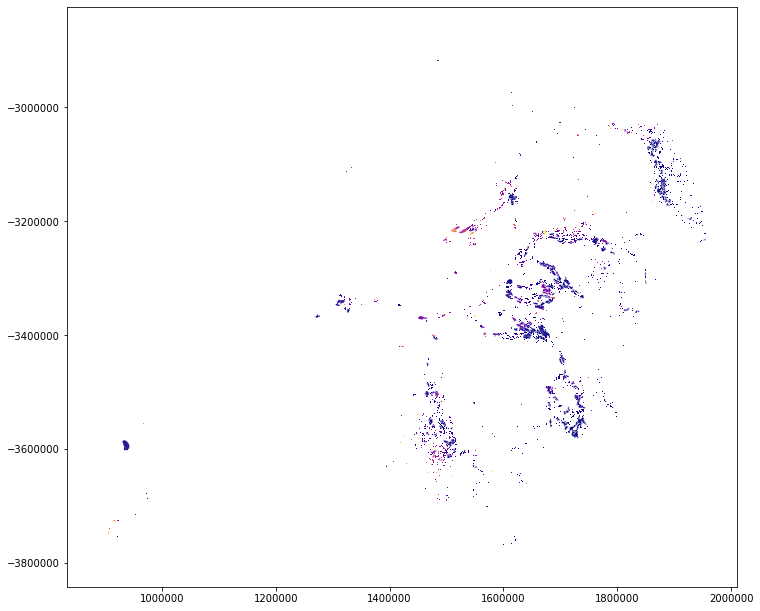

In [8]:
gdf_final.plot(cmap='plasma', column='firstObser',figsize=(12,12))